In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re


import pickle
from tqdm import tqdm
import os


from collections import Counter

## 1.1 Loading Data

In [2]:
data  = pd.read_csv('preprocessed_data.csv')
# data  = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
data.head(15)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
5,ca,mrs,grades_3_5,6,1,math_science history_civics,mathematics socialsciences,it end school year routines run course student...,102.50
6,ca,mrs,grades_3_5,0,1,literacy_language math_science,literacy mathematics,sitting still overrated it makes sense opera m...,1418.08
7,ca,ms,grades_3_5,0,0,math_science history_civics,appliedsciences history_geography,it not enough read book write essay connect de...,495.29
8,ca,ms,grades_prek_2,127,1,literacy_language,esl literacy,never society rapidly changed technology invad...,299.99
9,hi,mrs,grades_3_5,41,1,math_science,appliedsciences mathematics,do remember first time saw star wars wall e ro...,479.94


In [3]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [5]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent=sent.replace('0','')
    sent=sent.replace('1','')
    sent=sent.replace('2','')
    sent=sent.replace('3','')
    sent=sent.replace('4','')
    sent=sent.replace('5','')
    sent=sent.replace('6','')
    sent=sent.replace('7','')
    sent=sent.replace('8','')
    sent=sent.replace('9','')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [02:00<00:00, 908.90it/s]


In [6]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2> Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [11]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [12]:
l = []
l1 = []

# Make Data Model Ready: encoding essay, and project_title

In [13]:

vectorizer = CountVectorizer()
vectorizer.fit(X_train['essay'].values) 



X_train_essay_bow = vectorizer.transform(X_train['essay'].values)

X_test_essay_bow = vectorizer.transform(X_test['essay'].values)


print(X_train_essay_bow.shape, y_train.shape)

print(X_test_essay_bow.shape, y_test.shape)
print(vectorizer.get_feature_names())
k=list(vectorizer.get_feature_names())
l.extend(k)


# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

(73196, 48329) (73196,)
(36052, 48329) (36052,)
['00', '000', '000s', '001', '002', '003', '005nannan', '00am', '00p', '00pm', '01', '01075rm', '01g', '01ip', '02', '021', '022x10', '024', '03', '030', '0315', '034', '04', '041', '04112016', '05', '050', '059', '05pm', '06', '060', '07', '076', '077', '08', '084', '09', '0mp', '0my', '0nly', '0thanks', '0the', '0ver', '10', '100', '1000', '1000blackgirlbooks', '1000s', '100ft', '100m', '100s', '100th', '101', '1017', '102', '1020', '1022', '103', '104', '1043', '105', '1057', '106', '1065', '107', '1070', '1077', '108', '1082', '1084', '109', '1099', '10am', '10k', '10min', '10pk', '10pm', '10s', '10th', '10the', '10u', '10x', '10x10', '10yrs', '11', '110', '1100', '11000', '111', '111558', '111s', '112', '1120', '11242', '112th', '113', '113th', '114', '115', '1150', '116', '117', '1170l', '119', '11am', '11e', '11pm', '11th', '11x14', '11x17', '11x25', '12', '120', '1200', '12000', '1202', '1204', '120s', '120th', '1212', '122', '122

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,4),min_df=10)
vectorizer.fit(X_train['essay'].values) 

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)

X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)

print(X_test_essay_tfidf.shape, y_test.shape)

print(vectorizer.get_feature_names())
l1.extend(vectorizer.get_feature_names())

(73196, 257749) (73196,)
(36052, 257749) (36052,)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Make Data Model Ready: encoding numerical, categorical features

In [20]:

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 

X_train_teacher_bow = vectorizer.transform(X_train['teacher_prefix'].values)

X_test_teacher_bow = vectorizer.transform(X_test['teacher_prefix'].values)


print(X_train_teacher_bow.shape, y_train.shape)

print(X_test_teacher_bow.shape, y_test.shape)

print(vectorizer.get_feature_names())
l.extend(vectorizer.get_feature_names())




(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train['teacher_prefix'].values) 

X_train_teacher_tfidf = vectorizer.transform(X_train['teacher_prefix'].values)

X_test_teacher_tfidf = vectorizer.transform(X_test['teacher_prefix'].values)

print(X_train_teacher_tfidf.shape, y_train.shape)

print(X_test_teacher_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names())
l1.extend(vectorizer.get_feature_names())

(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [24]:
from sklearn.preprocessing import StandardScaler
standard_vec = StandardScaler(with_mean = False)
#converting into 2d array to avoid the error of expecting 2d
standard_vec.fit(X_train['price'].values.reshape(-1,1))

X_train_price_std = standard_vec.transform(X_train['price'].values.reshape(-1,1))

X_test_price_std = standard_vec.transform(X_test['price'].values.reshape(-1,1))


print(X_train_price_std.shape, y_train.shape)

print(X_test_price_std.shape, y_test.shape)
l.append("price")
l1.append("price")

(73196, 1) (73196,)
(36052, 1) (36052,)


In [26]:
standard_vec=StandardScaler(with_mean=False)
standard_vec.fit(X_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
X_train_posted_pr_std = standard_vec.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_test_posted_pr_std = standard_vec.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print(X_train_posted_pr_std.shape, y_train.shape)

print(X_test_posted_pr_std.shape, y_test.shape)

l.append(" teacher no. of previously posted projects")
l1.append("teacher no. of previously posted projects")



(73196, 1) (73196,)
(36052, 1) (36052,)


In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) 

X_train_clean_cat_bow = vectorizer.transform(X_train['clean_categories'].values)

X_test_clean_cat_bow = vectorizer.transform(X_test['clean_categories'].values)


print(X_train_clean_cat_bow.shape, y_train.shape)

print(X_test_clean_cat_bow.shape, y_test.shape)

print(vectorizer.get_feature_names())
l.extend(vectorizer.get_feature_names())



(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [30]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train['clean_categories'].values) 

X_train_clean_cat_tfidf = vectorizer.transform(X_train['clean_categories'].values)

X_test_clean_cat_tfidf = vectorizer.transform(X_test['clean_categories'].values)


print(X_train_clean_cat_tfidf.shape, y_train.shape)

print(X_test_clean_cat_tfidf.shape, y_test.shape)

print(vectorizer.get_feature_names())
l1.extend(vectorizer.get_feature_names())


(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [32]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) 

X_train_state_bow = vectorizer.transform(X_train['school_state'].values)

X_test_state_bow = vectorizer.transform(X_test['school_state'].values)


print(X_train_state_bow.shape, y_train.shape)

print(X_test_state_bow.shape, y_test.shape)

print(vectorizer.get_feature_names())
l.extend(vectorizer.get_feature_names())


(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [34]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train['school_state'].values) 

X_train_state_tfidf = vectorizer.transform(X_train['school_state'].values)

X_test_state_tfidf = vectorizer.transform(X_test['school_state'].values)


print(X_train_state_tfidf.shape, y_train.shape)

print(X_test_state_tfidf.shape, y_test.shape)

print(vectorizer.get_feature_names())
l1.extend(vectorizer.get_feature_names())


(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [36]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,3))
vectorizer.fit(X_train['project_grade_category'].values) 

X_train_project_grade_category_tfidf = vectorizer.transform(X_train['project_grade_category'].values)

X_test_project_grade_category_tfidf = vectorizer.transform(X_test['project_grade_category'].values)


print(X_train_project_grade_category_tfidf.shape, y_train.shape)

print(X_test_project_grade_category_tfidf.shape, y_test.shape)

print(vectorizer.get_feature_names())
l1.extend(vectorizer.get_feature_names())


(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [38]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) 

X_train_project_grade_category_bow = vectorizer.transform(X_train['project_grade_category'].values)

X_test_project_grade_category_bow = vectorizer.transform(X_test['project_grade_category'].values)


print(X_train_project_grade_category_bow.shape, y_train.shape)

print(X_test_project_grade_category_bow.shape, y_test.shape)

print(vectorizer.get_feature_names())
l.extend(vectorizer.get_feature_names())


(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [40]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) 

X_train_clean_subcategory_bow = vectorizer.transform(X_train['clean_subcategories'].values)

X_test_clean_subcategory_bow = vectorizer.transform(X_test['clean_subcategories'].values)


print(X_train_clean_subcategory_bow.shape, y_train.shape)

print(X_test_clean_subcategory_bow.shape, y_test.shape)

print(vectorizer.get_feature_names())
l.extend(vectorizer.get_feature_names())


(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [41]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(X_train['clean_subcategories'].values) 

X_train_clean_subcategory_tfidf = vectorizer.transform(X_train['clean_subcategories'].values)

X_test_clean_subcategory_tfidf = vectorizer.transform(X_test['clean_subcategories'].values)


print(X_train_clean_subcategory_tfidf.shape, y_train.shape)

print(X_test_clean_subcategory_tfidf.shape, y_test.shape)

print(vectorizer.get_feature_names())
l1.extend(vectorizer.get_feature_names())


(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [44]:
from scipy.sparse import hstack

In [45]:
bow_encoded_train=hstack((X_train_essay_bow,X_train_teacher_bow,X_train_price_std,X_train_posted_pr_std,X_train_clean_cat_bow,X_train_state_bow,X_train_project_grade_category_bow,X_train_clean_subcategory_bow))

bow_encoded_test=hstack((X_test_essay_bow,X_test_teacher_bow,X_test_price_std,X_test_posted_pr_std,X_test_clean_cat_bow,X_test_state_bow,X_test_project_grade_category_bow,X_test_clean_subcategory_bow))

tfidf_encoded_train=hstack((X_train_essay_tfidf,X_train_teacher_tfidf,X_train_price_std,X_train_posted_pr_std,X_train_clean_cat_tfidf,X_train_state_tfidf,X_train_project_grade_category_tfidf,X_train_clean_subcategory_tfidf))

tfidf_encoded_test=hstack((X_test_essay_tfidf,X_test_teacher_tfidf,X_test_price_std,X_test_posted_pr_std,X_test_clean_cat_tfidf,X_test_state_tfidf,X_test_project_grade_category_tfidf,X_test_clean_subcategory_tfidf))




# Appling NB on different kind of featurization 

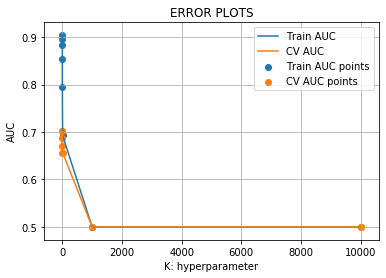

In [46]:
import math as m
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB( fit_prior=True, class_prior=[0.5,0.5])
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score


parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,1000,10000]}
clf2 = GridSearchCV(nb, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf2.fit(bow_encoded_train, y_train)
results=pd.DataFrame.from_dict(clf2.cv_results_)
results=results.sort_values("param_alpha")
k =  results['param_alpha']

train_auc= clf2.cv_results_['mean_train_score']
train_auc_std= clf2.cv_results_['std_train_score']
cv_auc = clf2.cv_results_['mean_test_score'] 
cv_auc_std= clf2.cv_results_['std_test_score']



plt.plot(parameters['alpha'], train_auc, label='Train AUC')


plt.plot(parameters['alpha'], cv_auc, label='CV AUC')


plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

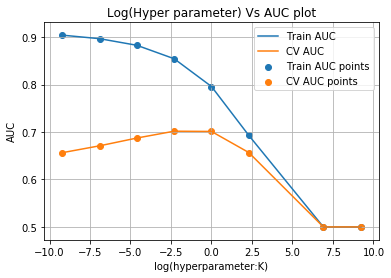

In [47]:
#log alpha vs auc score
log_alpha=[]
for i in k:
    log_alpha.append(m.log(i))
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')
plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(hyperparameter:K)")
plt.ylabel("AUC")
plt.title("Log(Hyper parameter) Vs AUC plot")
plt.grid()
plt.show()

In [48]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.239961,0.013324,0.022302,0.009830,0.0001,{'alpha': 0.0001},0.673838,0.657662,0.655031,0.646980,...,0.904446,0.904306,0.904126,0.904335,0.904972,0.903450,0.904599,0.904595,0.904320,0.000382
1,0.261528,0.021332,0.022401,0.003774,0.001,{'alpha': 0.001},0.686970,0.670366,0.669615,0.663059,...,0.896946,0.896855,0.896694,0.896945,0.897516,0.896011,0.897218,0.897263,0.896881,0.000405
2,0.239527,0.020600,0.017196,0.004000,0.01,{'alpha': 0.01},0.702431,0.683782,0.684366,0.680953,...,0.882905,0.882833,0.882740,0.883051,0.883529,0.882067,0.883323,0.883523,0.882930,0.000451
3,0.249137,0.031144,0.019294,0.005088,0.1,{'alpha': 0.1},0.716273,0.694573,0.696462,0.698266,...,0.854452,0.854208,0.854496,0.854752,0.854964,0.853710,0.854918,0.855613,0.854570,0.000520
4,0.264369,0.028845,0.021903,0.002704,1,{'alpha': 1},0.714553,0.694135,0.693603,0.703226,...,0.796040,0.795351,0.796196,0.796148,0.795714,0.795580,0.795747,0.798047,0.796053,0.000709
5,0.253738,0.023886,0.019996,0.002829,10,{'alpha': 10},0.670663,0.651845,0.651195,0.661990,...,0.693411,0.692097,0.693068,0.692648,0.692606,0.693769,0.692254,0.694746,0.693037,0.000884
6,0.244995,0.026605,0.016878,0.001827,1000,{'alpha': 1000},0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
7,0.251555,0.028888,0.016996,0.002973,10000,{'alpha': 10000},0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


Best alpha is 0.1

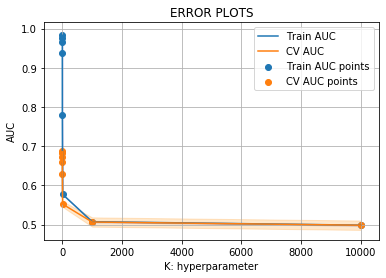

In [49]:

from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB( fit_prior=True, class_prior=[0.5,0.5])
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score


parameters = {'alpha':[0.0001,0.001,0.01,0.1,1,10,1000,10000]}
clf2 = GridSearchCV(nb, parameters, cv=10, scoring='roc_auc',return_train_score=True)
clf2.fit(tfidf_encoded_train, y_train)
results=pd.DataFrame.from_dict(clf2.cv_results_)
results=results.sort_values("param_alpha")
k=results["param_alpha"]

train_auc= clf2.cv_results_['mean_train_score']
train_auc_std= clf2.cv_results_['std_train_score']
cv_auc = clf2.cv_results_['mean_test_score'] 
cv_auc_std= clf2.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# copied: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# copied: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

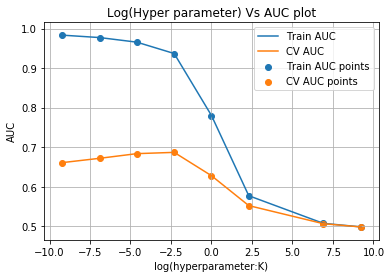

In [50]:
#log alpha vs auc score
log_alpha=[]
for i in k:
    log_alpha.append(m.log(i))
plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')
plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log(hyperparameter:K)")
plt.ylabel("AUC")
plt.title("Log(Hyper parameter) Vs AUC plot")
plt.grid()
plt.show()

In [51]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.748160,0.156155,0.081906,0.021729,0.0001,{'alpha': 0.0001},0.660337,0.667464,0.661091,0.652993,...,0.983245,0.983775,0.983359,0.983244,0.982906,0.982851,0.983160,0.982894,0.983207,0.000264
1,0.721056,0.069510,0.081904,0.015318,0.001,{'alpha': 0.001},0.673353,0.677339,0.670828,0.664599,...,0.977136,0.977786,0.977397,0.977162,0.976670,0.976677,0.976992,0.976745,0.977116,0.000338
2,0.703419,0.086849,0.081655,0.011962,0.01,{'alpha': 0.01},0.687635,0.687462,0.680873,0.677611,...,0.965389,0.966211,0.965964,0.965545,0.964812,0.964904,0.965205,0.965180,0.965467,0.000430
3,0.760851,0.069033,0.095406,0.039476,0.1,{'alpha': 0.1},0.691157,0.686436,0.681784,0.683223,...,0.936283,0.937532,0.937617,0.936580,0.935491,0.936171,0.936233,0.937487,0.936756,0.000677
4,0.798461,0.166954,0.089109,0.032854,1,{'alpha': 1},0.626491,0.624396,0.623497,0.633743,...,0.779483,0.779918,0.779562,0.779182,0.779811,0.779955,0.778816,0.781645,0.779974,0.000792
5,0.737453,0.110775,0.078407,0.015478,10,{'alpha': 10},0.545056,0.553473,0.551715,0.556193,...,0.577428,0.576533,0.577590,0.575324,0.578193,0.577927,0.576733,0.576628,0.577111,0.000810
6,0.703464,0.083673,0.079006,0.010910,1000,{'alpha': 1000},0.494502,0.508722,0.500814,0.521643,...,0.508038,0.505436,0.507556,0.505560,0.508063,0.509420,0.508104,0.504798,0.507222,0.001452
7,0.717666,0.113552,0.074397,0.003684,10000,{'alpha': 10000},0.487621,0.499138,0.490683,0.509049,...,0.499382,0.497148,0.499002,0.497102,0.498849,0.500276,0.499245,0.495304,0.498402,0.001423


Best alpha is 0.1

# 3. Summary


# Fitting using the best alpha in set 1 (preprocessed essay()bow)

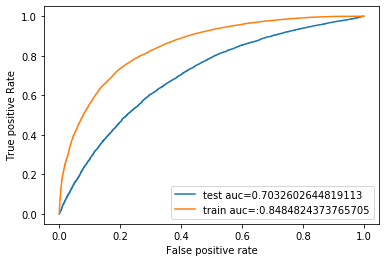

In [52]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


nb=MultinomialNB( alpha=0.1,fit_prior=True, class_prior=[0.5,0.5])#0.1 was found out to be the best alpha
nb.fit(bow_encoded_train,y_train)
y_pred_aux=nb.predict_proba(bow_encoded_test)
y_pred=[]
for i,j in y_pred_aux:
    y_pred.append(j)

y_train_pred_aux=[]
y_train_pred_aux=nb.predict_proba(bow_encoded_train)
y_train_pred=[]
for i,j in y_train_pred_aux:
    y_train_pred.append(j)
roc_auc_score(y_test,y_pred)
train_fpr,train_tpr,train_tr=roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,test_tr=roc_curve(y_test,y_pred)
plt.plot(test_fpr,test_tpr,label="test auc="+str(roc_auc_score(y_test,y_pred)))

plt.plot(train_fpr,train_tpr,label="train auc=:" +str(roc_auc_score(y_train,y_train_pred)))
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate")
plt.legend()



# Top 20 features in bow encoded data

In [53]:
Feature_probability_value=nb.feature_log_prob_
feature_probablity=nb.feature_log_prob_.argsort()
feature_probablity=feature_probablity[::-1]

print("Probalities of features on positive class and feature names")
for i in range(0,20):
    print(l[feature_probablity[0][i]],"  ",Feature_probability_value[0][feature_probablity[0][i]])

Probalities of features on positive class and feature names
coasted    -14.21492286980739
startups    -14.21492286980739
lingard    -14.21492286980739
dulch    -14.21492286980739
ascribed    -14.21492286980739
reforming    -14.21492286980739
classif    -14.21492286980739
linguistical    -14.21492286980739
lingusticaly    -14.21492286980739
germinates    -14.21492286980739
starling    -14.21492286980739
starke    -14.21492286980739
linocut    -14.21492286980739
oceano    -14.21492286980739
gererational    -14.21492286980739
ascertaining    -14.21492286980739
gerbils    -12.680992509881436
geoscience    -14.21492286980739
clasp    -14.21492286980739
aspira    -14.21492286980739


In [54]:
Feature_probability_value=nb.feature_log_prob_
feature_probablity=nb.feature_log_prob_.argsort()
feature_probablity=feature_probablity[::-1]

print("Probalities of features on negative class and feature names")
for i in range(0,20):
    print(l[feature_probablity[1][i]],"  ",Feature_probability_value[1][feature_probablity[1][i]])

Probalities of features on negative class and feature names
kitchenette    -15.345887456471429
loners    -15.99251462139648
loner    -15.345887456471429
loneliness    -13.879550387678002
london    -14.458584261470527
lombardii    -15.99251462139648
lombardi    -13.594619348598112
lombard    -15.99251462139648
lomax    -15.345887456471429
lom    -15.99251462139648
lollipops    -13.594619348598112
lolita    -15.99251462139648
lola    -15.99251462139648
loitering    -15.99251462139648
loisour    -15.99251462139648
loins    -15.99251462139648
lohs    -15.345887456471429
logon    -14.956422689709706
logitech    -14.676837827490544
logitec    -15.99251462139648


# confusion matrix

In [55]:
#copied:https://www.kaggle.com/agungor2/various-confusion-matrix-plots
from sklearn.metrics import confusion_matrix
import seaborn as sn
y_pred_bin=nb.predict(bow_encoded_test)
y_test=y_test.reshape(-1,1)

data = np.array(confusion_matrix(y_test, y_pred_bin))
np.set_printoptions(suppress=True)
print("confusion_matrix")
print(data)


confusion_matrix
[[ 3138  2321]
 [ 8241 22352]]


# fitting using the best alpha (preprocessed essay(tfidf))

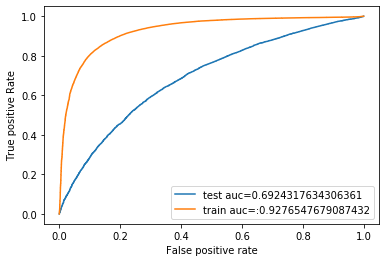

In [56]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


nb=MultinomialNB( alpha=0.1,fit_prior=True, class_prior=[0.5,0.5])#0.1 was found out to be the best alpha
nb.fit(tfidf_encoded_train,y_train)
y_pred_bin=nb.predict(tfidf_encoded_test)
y_pred_aux=nb.predict_proba(tfidf_encoded_test)
y_pred=[]
for i,j in y_pred_aux:
    y_pred.append(j)

y_train_pred_aux=[]
y_train_pred_aux=nb.predict_proba(tfidf_encoded_train)
y_train_pred=[]
for i,j in y_train_pred_aux:
    y_train_pred.append(j)
roc_auc_score(y_test,y_pred)
train_fpr,train_tpr,train_tr=roc_curve(y_train,y_train_pred)
test_fpr,test_tpr,test_tr=roc_curve(y_test,y_pred)
plt.plot(test_fpr,test_tpr,label="test auc="+str(roc_auc_score(y_test,y_pred)))

plt.plot(train_fpr,train_tpr,label="train auc=:" +str(roc_auc_score(y_train,y_train_pred)))
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate")
plt.legend()



# confusion matrix

In [57]:
#copied:https://www.kaggle.com/agungor2/various-confusion-matrix-plots
from sklearn.metrics import confusion_matrix
y_test=y_test.reshape(-1,1)

data = np.array(confusion_matrix(y_test, y_pred_bin))
np.set_printoptions(suppress=True)
print("confusion matrix")
print(data)

confusion matrix
[[ 2480  2979]
 [ 6310 24283]]


# Top 20 features in tfidf encoded data

In [58]:
Feature_probability_value=nb.feature_log_prob_
feature_probablity=nb.feature_log_prob_.argsort()
feature_probablity=feature_probablity[::-1]

print("Probalities of features on positive class and feature names")
for i in range(0,20):
    print(l1[feature_probablity[0][i]],"  ",Feature_probability_value[0][feature_probablity[0][i]])

Probalities of features on positive class and feature names
fitness is fun    -13.457670813286958
show fitness is    -13.457670813286958
fitness is fun big    -13.457670813286958
show fitness is fun    -13.457670813286958
let show fitness is    -13.457670813286958
fitness is    -13.457670813286958
is fun big    -13.457670813286958
is fun big part    -13.457670813286958
people the students requested    -13.457670813286958
appreciated approximately    -13.464106313543553
greatly appreciated approximately    -13.464106313543553
greatly appreciated approximately 560    -13.59008158349051
appreciated approximately 560    -13.59008158349051
appreciated approximately 560 students    -13.59008158349051
healthier people the students    -13.464106313543553
social emotional needs well    -12.760575185593186
live poverty line many    -12.70408472999165
harder our    -12.665698473819948
access excess 60 minutes    -13.470063197243148
students access excess    -13.470063197243148


In [59]:
Feature_probability_value=nb.feature_log_prob_
feature_probablity=nb.feature_log_prob_.argsort()
feature_probablity=feature_probablity[::-1]

print("Probalities of features on neagative class and feature names")
for i in range(0,20):
    print(l1[feature_probablity[1][i]],"  ",Feature_probability_value[1][feature_probablity[1][i]])

Probalities of features on neagative class and feature names
old boys girls ict    -13.880820383265569
problem in    -13.854561036228544
problem many not    -14.028719911233894
problem nannan    -12.957984701856947
focus current    -14.103447165719022
problem our school    -14.036950567358797
problem solve build    -13.93697154722291
problem solve my students    -13.649229318183366
problem solve world    -14.040683562428832
problem solve world issues    -14.040683562428832
problem solvers future    -13.83348772279892
problem solvers this    -13.955596267773622
problem however    -14.107650959820749
problem solvers tomorrow    -14.111285483308434
problem solving coding    -13.691532743580357
late hours    -14.00579874568453
focus community    -14.021804119708413
focus comfortable    -13.86527029725665
high school college the    -14.070538465722317
problem solving process    -13.84134675775807


In [60]:
from prettytable import PrettyTable

In [61]:
x = PrettyTable()

x.field_names = ["vectorizer", "model", "hyperparameter", "auc"]

x.add_row(["BOW", "multinomial naive bayes", "alpha", 0.70])
x.add_row(["TFIDF", "multinomail naive bayes", "alpha", 0.69])

In [62]:
print(x)

+------------+-------------------------+----------------+------+
| vectorizer |          model          | hyperparameter | auc  |
+------------+-------------------------+----------------+------+
|    BOW     | multinomial naive bayes |     alpha      | 0.7  |
|   TFIDF    | multinomail naive bayes |     alpha      | 0.69 |
+------------+-------------------------+----------------+------+
